#### General Loading + preprocessing
*followed preliminary example here: https://datascience.stackexchange.com/questions/26871/can-someone-spot-anything-wrong-with-my-lstm-forex-model/26876

In [102]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import tensorflow as tf
import yfinance as yf

from keras.models import Sequential
from keras.layers import LSTM, Dense, Flatten

In [137]:
#Loading params
#start_date = '2016-01-01'
start_date = '2008-01-01'
end_date = '2019-08-01'

In [166]:
#Load correlated data
datacorr = {}

##1 - euro/gbp
datacorr['eurgbp'] = yf.download('EURGBP=X',start_date,end_date2)

##2 - FTSE 100
datacorr['ftse'] = yf.download('^FTSE',start_date,end_date)

##3 - VIX (volatility index)
datacorr['vix'] = yf.download('^VIX',start_date,end_date)

##4 - euro/usd
datacorr['eurusd'] = yf.download('EURUSD=X',start_date,end_date)

##5 - DJI
datacorr['dji'] = yf.download('^DJI',start_date,end_date)

##6 - NASDAQ
datacorr['ixic'] = yf.download('^IXIC',start_date,end_date)

##7 - Nikkei225
datacorr['n225'] = yf.download('^N225',start_date,end_date)

##8 - usd/jpy
datacorr['usdjpy'] = yf.download('USDJPY=X',start_date,end_date)

##9 - gbp/jpy
datacorr['gbpjpy'] = yf.download('GBPJPY=X',start_date,end_date)

datacorr['usdcny'] = yf.download('USDCNY=X',start_date,end_date)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [27]:
def scale(X):
    Xmax = max(X)
    Xmin = min(X)
    return (X-Xmin)/(Xmax - Xmin)

In [155]:
#Get other features and concatenate with Closes of other markets

num_features = 4 + len(datacorr.keys()) #4 for GBP/USD and 9 other closes
#Load main data
data = yf.download('GBPUSD=X',start_date,end_date)

#align dates for all features
for f in datacorr.keys():
    data = data.join(datacorr[f],on='Date', how='outer', rsuffix='_'+f).dropna()
    
x = np.zeros((data.shape[0],num_features))
#store in x
##first 4
datCols = ['Open','Close','High','Low']
for cc,col in enumerate(datCols):
    x[:,cc] = scale(data[col].values)

#next 9
for ff,f in enumerate(datacorr.keys()):
    x[:,ff+4] = scale(data['Close_'+f].values)

[*********************100%***********************]  1 of 1 completed


In [156]:
#Get labels
outlook = 1
y_df = data['Close']<data['Close'].shift(-outlook)
y = 1*y_df.values
print(len(y))

2670


In [157]:
#Split data!
train_split = 0.8
total_count = x.shape[0]
train_cut = int(total_count* train_split)

x_train = x[: train_cut-1, :]
x_test = x[train_cut :, :]
y_train = y[: train_cut-1]
y_test = y[train_cut :]

In [165]:
#Train model!

### Constants
num_time_steps = 60   # Num of steps in batch (also used for prediction steps into the future)
num_features = num_features   # Number of features
num_neurons = 97
num_outputs = 1 # Just one output (True/False), predicted time series
learning_rate = 0.0001 # learning rate, 0.0001 default, but you can play with this
nb_epochs = 15 # how many iterations to go through (training steps), you can play with this
batch_size = 25

model = Sequential()
stacked = False
stacked = True
if stacked == True:
    model.add(LSTM(num_neurons, return_sequences=True, input_shape=(num_time_steps,num_features), activation='relu', dropout=0.5))
    model.add(LSTM(num_neurons, activation='relu', dropout=0.5))
else:
    model.add(LSTM(num_neurons, input_shape=(num_time_steps,num_features), activation='relu', dropout=0.5))

#model.add(Flatten())
model.add(Dense(units=num_outputs, activation='sigmoid'))

model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics=['accuracy'])

look_back = num_time_steps
x_train_reshape = create_dataset(x_train, look_back=look_back)
y_train_reshape = y_train[(look_back-1):]
x_test_reshape = create_dataset(x_test, look_back=look_back)
y_test_reshape = y_test[(look_back-1):]
history = model.fit(x_train_reshape,
                    y_train_reshape,
                    batch_size = batch_size,
                    epochs = nb_epochs,
                    validation_data=(x_test_reshape, y_test_reshape))

Train on 2076 samples, validate on 475 samples
Epoch 1/30
2076/2076 [==============================] - 8s 4ms/step - loss: 0.6964 - accuracy: 0.4827 - val_loss: 0.6929 - val_accuracy: 0.5116
Epoch 2/30
2076/2076 [==============================] - 7s 3ms/step - loss: 0.6930 - accuracy: 0.5173 - val_loss: 0.6932 - val_accuracy: 0.5116
Epoch 3/30
2076/2076 [==============================] - 7s 3ms/step - loss: 0.6939 - accuracy: 0.5010 - val_loss: 0.6929 - val_accuracy: 0.5116
Epoch 4/30
2076/2076 [==============================] - 7s 3ms/step - loss: 0.6936 - accuracy: 0.5159 - val_loss: 0.6932 - val_accuracy: 0.5137
Epoch 5/30
2076/2076 [==============================] - 6s 3ms/step - loss: 0.6937 - accuracy: 0.5039 - val_loss: 0.6928 - val_accuracy: 0.5116
Epoch 6/30
2076/2076 [==============================] - 7s 3ms/step - loss: 0.6932 - accuracy: 0.5294 - val_loss: 0.6927 - val_accuracy: 0.5116
Epoch 7/30
2076/2076 [==============================] - 7s 4ms/step - loss: 0.6930 - accu

In [111]:
def create_dataset(dataset, look_back=1):
    #dataX, dataY = [], []
    dataX= []
    for i in range(len(dataset)-look_back+1):
        a = dataset[i:(i+look_back), :]
        dataX.append(a)
        #dataY.append(dataset[i + look_back - 1, :])
    #return np.array(dataX), np.array(dataY)
    return np.array(dataX)

In [167]:
score, acc = model.evaluate(x_test_reshape, y_test_reshape,
                            batch_size=batch_size)
print("Test accuracy: ", acc)
score, acc = model.evaluate(x_train_reshape, y_train_reshape,
                            batch_size=batch_size)
print("Train accuracy: ", acc)

475/475 [==============================] - 0s 768us/step
Test accuracy:  0.5115789771080017
2076/2076 [==============================] - 2s 743us/step
Train accuracy:  0.5163776278495789


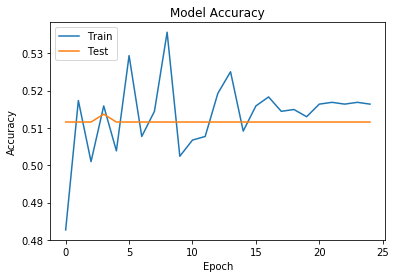

In [169]:
plt.plot(history.history['accuracy'][:25])
plt.plot(history.history['val_accuracy'][:25])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

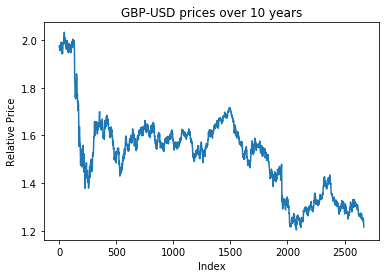

In [164]:
plt.plot(data['Close'].values)
plt.xlabel('Index')
plt.ylabel('Relative Price')
plt.title('GBP-USD prices over 10 years')
plt.show()